# 股价预测专题

In [1]:
# 必要的库
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler  # 进行归一化操作

# 自行编写的包
sys.path.append('/home/ubuntu/notebooks/pycharm_projects/Investor-Sentiment')


2023-03-12 05:12:07.468041: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## 数据准备

### 参数区

In [2]:
# 特征工程和数据集
factor_column = ['close', 'img_neg', 'tex_neg', 'SENT_INDEX', 'SENT_INDEX_R']
# factor_column = ['close']
df_data = pd.read_csv('/data/DataSets/investor_sentiment/FINAL_DATA_2014_2021.csv', usecols=factor_column)
df_data = df_data[factor_column]  #第一个是标签

# 参数区
TIME_STEPS = 1  # 时间窗
FORECAST_STEPS = 5  # 未来步长
BATCH_SIZE = 1024
EPOCHS = 100
FEATURES = len(factor_column)  # 特征
train_size, val_size = int(len(df_data) * 0.6), int(len(df_data) * 0.8)  #训练集,测试集

In [3]:
df_data

,close,img_neg,tex_neg,SENT_INDEX,SENT_INDEX_R
0,2900.6300,0.000000,0.000000,-0.932715,-1.191905
1,2874.3200,0.000000,0.333333,-0.928031,-1.182604
2,2803.2900,0.285714,0.142857,-0.917702,-1.175354
3,2814.1000,0.000000,0.333333,-0.914326,-1.172984
4,2825.8200,0.333333,0.000000,-0.931606,-1.185114
...,...,...,...,...,...
1939,5897.1579,0.220339,0.152542,0.597233,0.390557
1940,5939.4153,0.047619,0.238095,1.426782,1.186737
1941,5885.3073,0.250000,0.350000,0.202870,0.013389
1942,5935.2719,0.388889,0.277778,1.203630,0.972127


### 数据集转换

In [4]:
# 归一化 将数据缩放到 [0, 1] 范围内
Scaler = MinMaxScaler()
df_std = Scaler.fit_transform(df_data)

# 将数据集分为训练集,验证集和测试集
train_data, val_data, test_data = df_std[0:train_size, :], df_std[train_size:val_size, :], df_std[val_size:, :]


# 将时间序列数据转换为监督学习数据
def create_dataset(dataset, look_back=TIME_STEPS, forecast=FORECAST_STEPS):
    x, y = [], []
    for i in range(len(dataset) - look_back - forecast + 1):
        x.append(dataset[i:(i + look_back), :])  # 已经包含了过去的数据
        y.append(dataset[(i + look_back):(i + look_back + forecast), 0])  #第一个是标签
    return np.array(x), np.array(y)


# 生成训练集和测试集
train_X, train_Y = create_dataset(train_data, TIME_STEPS)
val_X, val_Y = create_dataset(val_data, TIME_STEPS)
test_X, test_Y = create_dataset(test_data, TIME_STEPS)
test_X.shape, test_Y.shape,  # [样本数, 时间步数, 特征数]

((384, 1, 5), (384, 5))

## 模型构建

In [5]:
# 构建LSTM模型
model = Sequential([
        LSTM(units=64, input_shape=(TIME_STEPS, FEATURES), return_sequences=True),
        Dropout(0.2),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        LSTM(units=64),
        Dropout(0.2),
        Dense(units=FORECAST_STEPS, activation='sigmoid')  #预测步长
])

# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2023-03-12 05:12:08.781063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-12 05:12:08.788105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-12 05:12:08.789664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-12 05:12:08.791805: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFl

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             17920     
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             33024     
                                                                 
 dropout_1 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 64)             33024     
                                                                 
 dropout_2 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                3

## 模型训练

In [6]:
# 训练模型
history = model.fit(train_X, train_Y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_X, val_Y), verbose=2)

Epoch 1/100


2023-03-12 05:12:15.404817: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/miniconda3/envs/Rapids/lib/python3.9/site-packages/tensorflow/python/../../../../libcublas.so.11: undefined symbol: cublasGetSmCountTarget


2/2 - 6s - loss: 0.6931 - accuracy: 0.1895 - val_loss: 0.6921 - val_accuracy: 0.1693 - 6s/epoch - 3s/step
Epoch 2/100
2/2 - 0s - loss: 0.6924 - accuracy: 0.2308 - val_loss: 0.6910 - val_accuracy: 0.2682 - 32ms/epoch - 16ms/step
Epoch 3/100
2/2 - 0s - loss: 0.6916 - accuracy: 0.2412 - val_loss: 0.6899 - val_accuracy: 0.3151 - 30ms/epoch - 15ms/step
Epoch 4/100
2/2 - 0s - loss: 0.6907 - accuracy: 0.2317 - val_loss: 0.6887 - val_accuracy: 0.3203 - 29ms/epoch - 14ms/step
Epoch 5/100
2/2 - 0s - loss: 0.6899 - accuracy: 0.2394 - val_loss: 0.6875 - val_accuracy: 0.3203 - 29ms/epoch - 14ms/step
Epoch 6/100
2/2 - 0s - loss: 0.6890 - accuracy: 0.2506 - val_loss: 0.6861 - val_accuracy: 0.3203 - 29ms/epoch - 15ms/step
Epoch 7/100
2/2 - 0s - loss: 0.6880 - accuracy: 0.2446 - val_loss: 0.6846 - val_accuracy: 0.3203 - 30ms/epoch - 15ms/step
Epoch 8/100
2/2 - 0s - loss: 0.6869 - accuracy: 0.2351 - val_loss: 0.6830 - val_accuracy: 0.3203 - 30ms/epoch - 15ms/step
Epoch 9/100
2/2 - 0s - loss: 0.6858 - ac

12/12 [==============================] - 1s 2ms/step


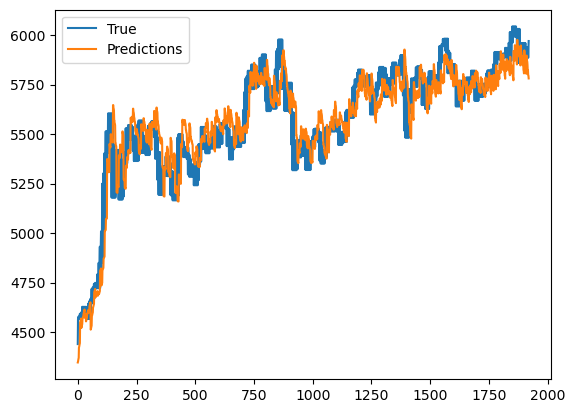

In [7]:
# 预测
pred_Y = model.predict(test_X).reshape(-1, 1)
test_Y = test_Y.reshape(-1, 1)

# 反缩放预测结果
pred_Y_sc = Scaler.inverse_transform(np.concatenate((pred_Y, np.zeros((len(pred_Y), FEATURES - 1))), axis=1))[:, 0]
test_Y_sc = Scaler.inverse_transform(np.concatenate((test_Y, np.zeros((len(test_Y), FEATURES - 1))), axis=1))[:, 0]

# 计算预测误差
mse = np.mean((pred_Y_sc - test_Y_sc) ** 2)
mape = np.mean(np.abs((test_Y_sc - pred_Y_sc) / test_Y_sc)) * 100

# 可视化预测结果
plt.plot(test_Y_sc, label='True')
plt.plot(pred_Y_sc, label='Predictions')
plt.legend()

In [8]:
mse, mape

(13265.642862471208, 1.58600836450025)

## 循环预测

In [28]:

def predict_stock_price():
    # input_data = test_X[0]  # 获取测试集最后一个时间步的数据作为起始点
    predictions = []  # 存储预测结果

    for i in range(len(test_X)):
        # 将输入数据重塑为LSTM模型所需的形状
        input_data = test_X[i].reshape(1, TIME_STEPS, FEATURES)  # 测试集中第一条数据

        # 使用LSTM模型进行预测
        pred_y = model.predict(input_data).reshape(-1, 1)
        # print(pred_y)

        # 将预测结果添加到预测列表中
        # predictions.append(pred_y[0][0])

        # 将预测结果作为下一个时间步长的输入数据
        # input_data = np.append(input_data[:, 1:, :], input_data, axis=1)

    # 对预测结果进行反归一化处理
    # pred_y_sc = Scaler.inverse_transform(np.concatenate((pred_y, np.zeros((len(pred_y), FEATURES - 1))), axis=1))[:, 0]

    return predictions


predict_stock_price()



1/1 [==============================] - 0s 16ms/step


array([4346.13788802, 4350.1431523 , 4359.32490775, 4364.44053769,
       4369.56383394])